In [ ]:
!pip install nptdms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nptdms: filename=npTDMS-1.7.0-py3-none-any.whl size=104706 sha256=711aae511703ac595eda130d28cda2e17b54c6067a3b306ab9fd7bb39cabfef7
  Stored in directory: /root/.cache/pip/wheels/24/61/d6/bdb3426f132dc4ae7ecb0606257c0cb108f332025008d29750
Successfully built nptdms


In [ ]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nptdms import TdmsFile
import numpy as np
from scipy.signal import butter, lfilter, freqz, firwin, gaussian
import scipy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Flatten, TimeDistributed, Reshape, Lambda
from tensorflow.keras.models import Model
from keras.optimizers import Adam
import h5py
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data Preprocessing

In [ ]:
def reshape_raster(data,sX):
    arr = []
    for i in range(data.shape[0]//sX):
        xi = data[sX*i: sX*(i+1)]
        if i%2 == 1:
            xi = xi[::-1]
        arr.append(xi)
    data = np.array(arr)
    return data

def segment(X_train, w=5,s=1):
    N = (len(X_train)-w)//s+1
    X = []
    for i in range(N):
        X.append(X_train[i*s:i*s+w].reshape(-1))
    X = np.array(X)
    X = X[:,:,None]
    return X

def mean_std(data,axis = 0):
    mean = np.mean(data , axis = axis, keepdims = True)
    std = np.std(data, axis = axis, keepdims = True) + 1e-9
    # normalized_data = (data - mean) / st
    return mean, std

def standard_normalize(data,axis = 0):
    mean = np.mean(data , axis = axis, keepdims = True)
    std = np.std(data, axis = axis, keepdims = True) + 1e-9
    normalized_data = (data - mean) / std
    return normalized_data

def get_callbacks(patience = 10):
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience//2, min_lr=1e-12, verbose=1)
    # early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
    # checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True)
    return [reduce_lr]

In [ ]:
def loadscan_tdms(file):

    tdms_file = TdmsFile.read(file)
    # tdms_file.groups()
    group1 = tdms_file['Freq_Sampling_SizeX_SizeY']
    infor = group1.channels()[0]
    f = infor[:][0]; sampling = infor[:][1]; sX = int(infor[:][2]); sY = int(infor[:][3])
    samples = int(sampling/f)

    group2 = tdms_file['Waveform']
    data = group2.channels()[0][:]
    X_scan = np.reshape(data,(-1,samples))

    return X_scan, sX, samples


def read_scan_tdms(file, thickness, lof, raster=False):
    data, sX, samples = loadscan_tdms(file)
    if samples > 500:
        samples = samples // 4
        idx = np.arange(0, len(data[0]), 4)
        data = data[:, idx]
    sY = data.shape[0] // sX

    if raster:
        data = reshape_raster(data, sX)

    thickness_label = np.array(thickness).reshape(-1, 1)
    lof_label = np.array(lof).reshape(-1, 1)

    data_with_labels = np.concatenate((data, thickness_label, lof_label), axis=1)

    data_with_labels = data_with_labels[:, :, np.newaxis]

    return data_with_labels



def read_tdms_folder(folder_path, label):
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.tdms')]

    all_data = []

    def read_scan_tdms(file, raster=False):
        data, _, _ = loadscan_tdms(file)
        return data

    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)
        data = read_scan_tdms(file_path)
        all_data.append(data)

    all_data = np.array(all_data)
    all_data = all_data.reshape(-1, all_data.shape[2])
    all_data = np.expand_dims(all_data, axis=2)

    labels = np.full((all_data.shape[0], 1, 1), label)
    labeled_data = np.concatenate((all_data, labels), axis=1)

    return labeled_data

def read_folder_data(folder_path, thickness, lof_values):
    data_list = []

    for lof_value in lof_values:
        lof_array = np.full((915, 1), lof_value)
        file_path = os.path.join(folder_path, f'lof_{lof_value}_mm.tdms')
        data = read_scan_tdms(file_path, lof_array, thickness)
        data_list.append(data)


    combined_data = np.concatenate(data_list, axis=0)

    return combined_data

In [ ]:
def read_scan_tdms_1_0(file,raster=False):
    data, sX, samples = loadscan_tdms(file)
    if samples > 500:
        samples = samples//4
        idx = np.arange(0,len(data[0]),4)
        data = data[:,idx]
    sY = data.shape[0]//sX

    if raster:
        data = reshape_raster(data,sX)
    return data

In [ ]:
thickness_1 = read_scan_tdms_1_0('/content/drive/MyDrive/steel_thickness_data_2.0/1mm/lof_0.5_mm.tdms')

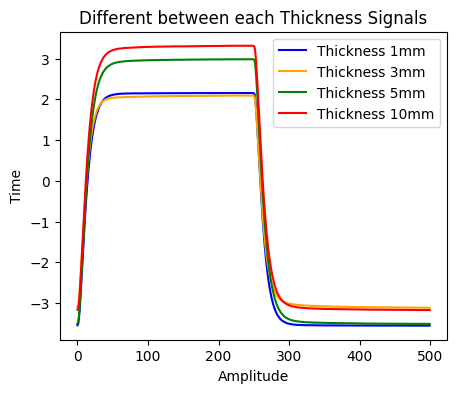

In [ ]:
thickness_1 = read_scan_tdms_1_0('/content/drive/MyDrive/steel_thickness_data_2.0/1mm/lof_2_mm.tdms')
thickness_3 = read_scan_tdms_1_0('/content/drive/MyDrive/steel_thickness_data_2.0/3mm/lof_2_mm.tdms')
thickness_5 = read_scan_tdms_1_0('/content/drive/MyDrive/steel_thickness_data_2.0/5mm/lof_2_mm.tdms')
thickness_10 = read_scan_tdms_1_0('/content/drive/MyDrive/steel_thickness_data_2.0/10mm/lof_2_mm.tdms')

lof_0_5 = read_scan_tdms_1_0('/content/drive/MyDrive/steel_thickness_data_2.0/4mm/lof_0.5_mm.tdms')
lof_1 = read_scan_tdms_1_0('/content/drive/MyDrive/steel_thickness_data_2.0/4mm/lof_1_mm.tdms')
lof_2 = read_scan_tdms_1_0('/content/drive/MyDrive/steel_thickness_data_2.0/4mm/lof_2_mm.tdms')

plt.figure(figsize=(5, 4))

first_sample_1 = thickness_1[800]
plt.plot(first_sample_1.T, label='Thickness 1mm', color='blue')
first_sample_3 = thickness_3[800]
plt.plot(first_sample_3.T, label='Thickness 3mm', color='orange')
first_sample_5 = thickness_5[800]
plt.plot(first_sample_5.T, label='Thickness 5mm', color='green')
first_sample_10 = thickness_10[800]
plt.plot(first_sample_10.T, label='Thickness 10mm', color='red')
plt.title('Different between each Thickness Signals')
plt.xlabel('Amplitude')
plt.ylabel('Time')
plt.legend()

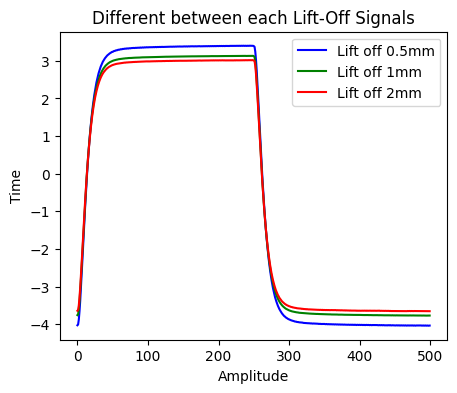

In [ ]:
plt.figure(figsize=(5, 4))
lof_0_5 = lof_0_5[800]
plt.plot(lof_0_5.T, label='Lift off 0.5mm', color='blue')
lof_1 = lof_1[800]
plt.plot(lof_1.T, label='Lift off 1mm', color='green')
lof_2 = lof_2[800]
plt.plot(lof_2.T, label='Lift off 2mm', color='red')
plt.xlabel('Amplitude')
plt.ylabel('Time')
plt.title('Different between each Lift-Off Signals')
plt.legend()
plt.show()

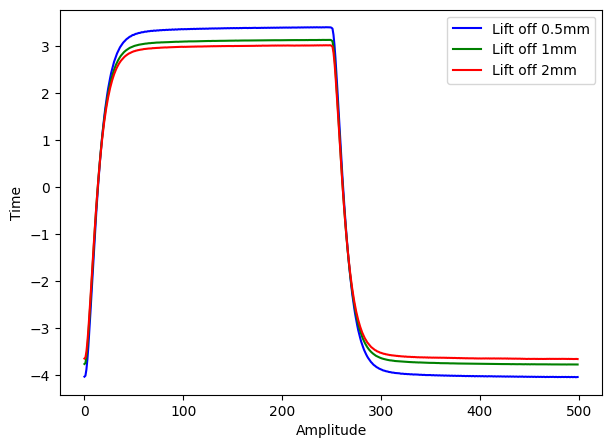

In [ ]:
lof_0_5 = read_scan_tdms_1_0('/content/drive/MyDrive/steel_thickness_data_2.0/4mm/lof_0.5_mm.tdms')
lof_1 = read_scan_tdms_1_0('/content/drive/MyDrive/steel_thickness_data_2.0/4mm/lof_1_mm.tdms')
lof_2 = read_scan_tdms_1_0('/content/drive/MyDrive/steel_thickness_data_2.0/4mm/lof_2_mm.tdms')

plt.figure(figsize=(7, 5))

lof_0_5 = lof_0_5[800]
plt.plot(lof_0_5.T, label='Lift off 0.5mm', color='blue')

lof_1 = lof_1[800]
plt.plot(lof_1.T, label='Lift off 1mm', color='green')

lof_2 = lof_2[800]
plt.plot(lof_2.T, label='Lift off 2mm', color='red')

plt.xlabel('Amplitude')
plt.ylabel('Time')
plt.legend()
plt.legend()
plt.show()

In [ ]:
thickness_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
lof_values = [0.5, 1, 2]

folder_paths = ['/content/drive/My Drive/steel_thickness_data_2.0/{0}mm/'.format(thickness) for thickness in thickness_values]
thickness_data = [np.full((915, 1), thickness) for thickness in thickness_values]

thickness_data_list = []

for folder_path, thickness_value in zip(folder_paths, thickness_data):
    data = read_folder_data(folder_path, thickness_value, lof_values)
    thickness_data_list.append(data)


df = np.concatenate(thickness_data_list, axis=0)
df.shape

(27450, 502, 1)

In [ ]:
X = df[:, :-2, :]
y = df[:, -2:, :]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(19215, 500, 1)
(8235, 500, 1)
(19215, 2, 1)
(8235, 2, 1)


In [ ]:
h5_file_name = 'steel_data.h5'
destination_path = '/content/drive/MyDrive/' + h5_file_name

with h5py.File(destination_path, 'w') as hf:
    hf.create_dataset('X_train', data=X_train)
    hf.create_dataset('X_test', data=X_test)
    hf.create_dataset('y_train', data=y_train)
    hf.create_dataset('y_test', data=y_test)